## Advanced Techniques for Complex Time Series

Timeseries data can contain complex seasonality - for example, recorded hourly data can exhibit daily, weekly and yearly seasonal patterns. With the rise of connected devices - IoT and sensors - data is being recorded more frequently. For example, if we examine classical time series datasets used in many research papers, many were smaller sets and recorded less frequently, such as annually or monthly. Such data contains one seasonal pattern. More recent datasets and research now use higher frequency data, recorded in hours or minutes. 

Here we will explore new algorithms that can model a time series with multiple seasonality for forecasting and decomposing a time series into different components. 

Here we will explore the following topics:

* Decomposing time series with multiple seasonal patterns **MSTL**
* Forecasting with multiple seasonal patterns using the **Unobserved Components Model (UCM)**
* Forecasting time series with multiple seasonal patterns using **Prophet**
* Forecasting time series with multiple seasonal patterns using **NeuralProphet**


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pathlib import Path
from statsmodels.tools.eval_measures import rmse, rmspe 
import warnings 
warnings.filterwarnings('ignore')


In [2]:
folder = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/AEP_hourly.csv')

df = pd.read_csv(folder, index_col='Datetime', parse_dates=True)

In [3]:
# Clean up the data 

df.sort_index(inplace=True)
df = df.resample('H').max()
df.ffill(inplace=True)

## Understanding state-space models

**State-Space Models (SSM)**

Have their roots in the field of engineering and offer a generic approach to modeling dynamic systems and how they evolve over time. In addition, SSMs are widely used in other fields, such as economics, neuroscience, electrical engineering etc. 

In time series data, the central idea behind SSMs is that of **latent variables**, also called **states**, which are continous and sequential through time-space domain. For example, in a univariate time series, we have a response variable at time **t**; this is the observed value termed **$Y_{t}$**, which depends on the true variable termed **$X_{t}$**. The **$X_{t}$** variable is the latent variable that we are interested in estimating - which is either **unobserved** or cannot be measured. In state space, we have an underlying state that we cannot measure directly (unobserved). An SSM provides a system of equations to estimate these unobserved states from the observed values and is represented mathematically in a vector-matrix form. In general, there are two equations - a _state equation_ and an _observed equation_. One key aspect of their popularity is their flexibility and ability to work with complex time series data that can be multivariate, non-stationary, non-linear or contain multiple seasonality, gaps or irregularities.

In addition, SSMs can be generalized and come in various forms, several of which make use of **Kalman filters**. The benefit of using SSMs in time series data is that they are used in _filtering, smoothing or forecasting_, as we will explore

**KALMAN FILTERS**
The Kalman filter is an algorithm for extracting signals from data that is either noisy or contains incomplete measurements. The premise behind Kalman filters is that not every state within a system is directly observable; instead, we can estimate the state indirectly, using observations that may be contaminated, incomplete or noisy

For example, sensor devices produce time series data known to be incomplete due to interruptions or unreliable due to noise. Kalman filters are excellent when working with time series data containing a considerable signal-to-noise ratio, as they work on smoothing and denoising the data to make it more reliable

## Decomposing time series with multiple seasonal patterns using MSTL



**Multiple STL Decomposition (MSTL)** is an extension of the STL algorithm and similarly is an additive decomposition, but it extends the equation to include multiple seasonal components and not just one: 

$Y_{t} = S_{t}^{1} + S_{t}^{2} +...+ S_{t}^{n} + T_{t} + R_{t}$

Here, n represents the number of seasonal cycles. The algorithm interatively fits the STL decomposition for each seasonal cycle (frequency identified) to get the decomposed seasonal components: $S_{t}^{1} + S_{t}^{2} +...+ S_{t}^{n}$

Once the iterative process for each seasonal cycle is completed, the trend component is estimated. If the time series does not have any seasonal components, MSTL will only estimate the trend

In Python, the algorithm is implemented in statsmodels as the MSTL class.

We need to install a _development_ version (0.14.0) of statsmodels, since this is the only version that has the MSTL class available 

In [7]:
from statsmodels.tsa.seasonal import MSTL
plt.rcParams["figure.figsize"] = [14, 10]

In [4]:
day = 24
week = day*7
month=round(week*4.35)
year=round(month*12)
print(f'''day = {day} hours 
week = {week} hours
month = {month} hours
year = {year} hours
''')

day = 24 hours 
week = 168 hours
month = 731 hours
year = 8772 hours



In [9]:
# Provide the different seasonal cycles we suspect - for exampl, a daily and weekly seasonal pattern

mstl = MSTL(df, periods=(day, week))

Since the data's frequency is hourly, a daily pattern is observed every 24 hoiurs and weekly every 24x7 or 168 hours 

In [10]:
# Use the fit method to fit the model. The algo will first estimate the two seasonal periods
# S_1{24} and S_2{24*7}, then the trend, and finally the remainder:

results = mstl.fit()

The results object is an instance of the DecomposeResult class, which gices access to the seasonal, trend and resid attributes. The seasonal attribute will display a DF with two columns labeled seasonal_24 and seasonal_168. We can plot each attribute individually or use the plot method to plot all the components:

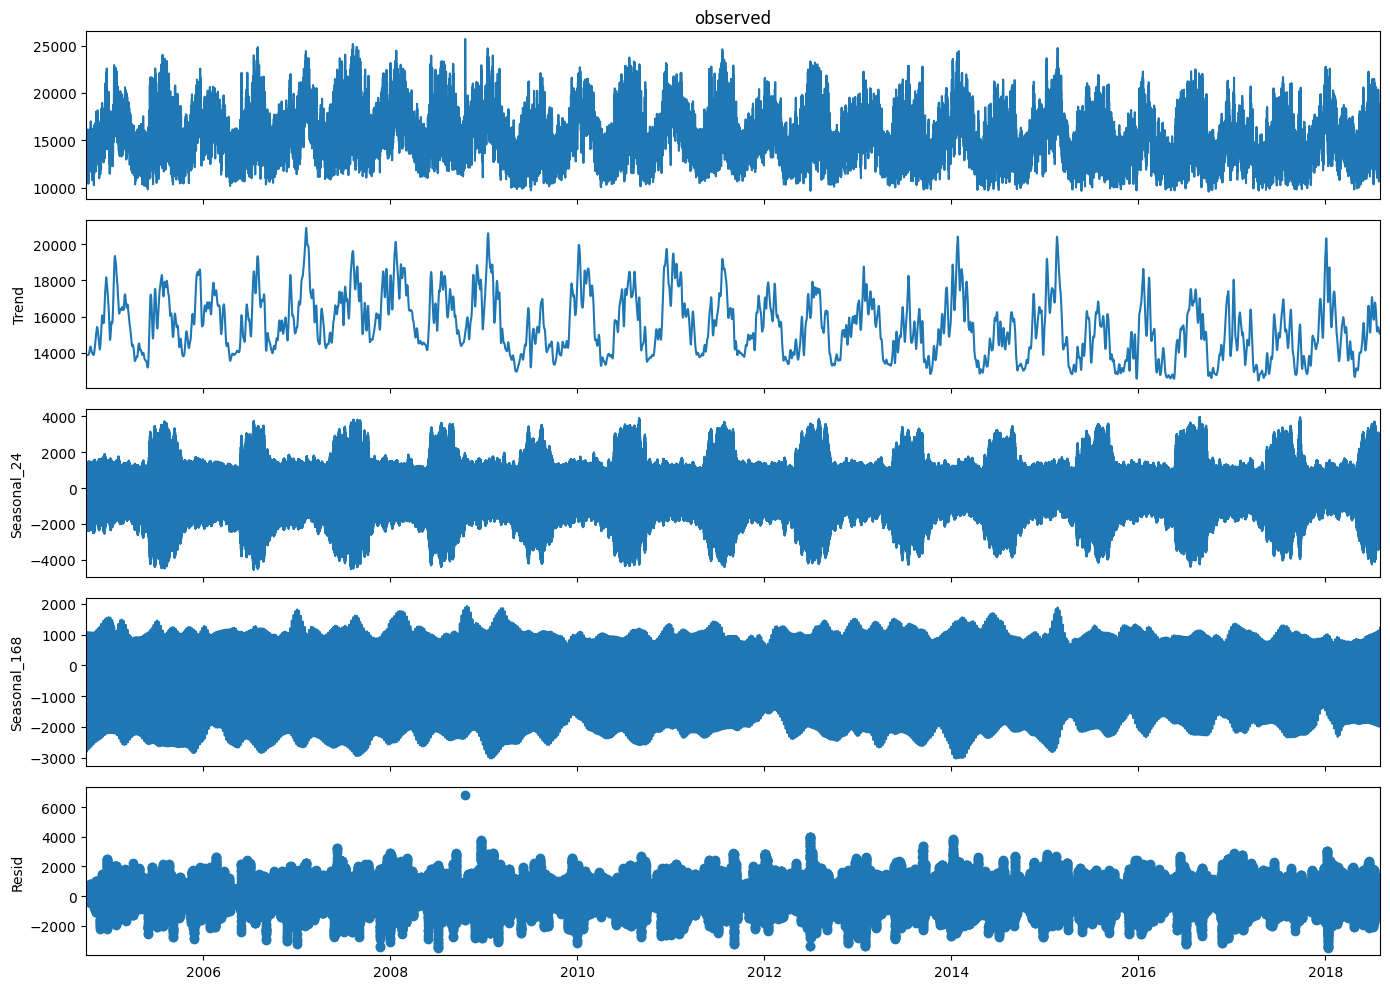

In [11]:
ax = results.plot()

The above produces five subplots for the observed_trend, seasonal_24 (daily), seasonal_168 (weekly) and resid (remainder) respectively.

Given the amount of data, it is hard to observe the extracted patterns. Slice the data to zoom in for a better visual perspective

Generally, we would expect a daily pattern where energy consumption peaks during the day and declines at nighttime. Additionally, we would anticipate a weekly pattern where consumption is higher on weekdays compared to weekends when people travel or go outside more. An annual pattern is also expected, with higher energy consumption peaking in the summer than in other cooler months. 



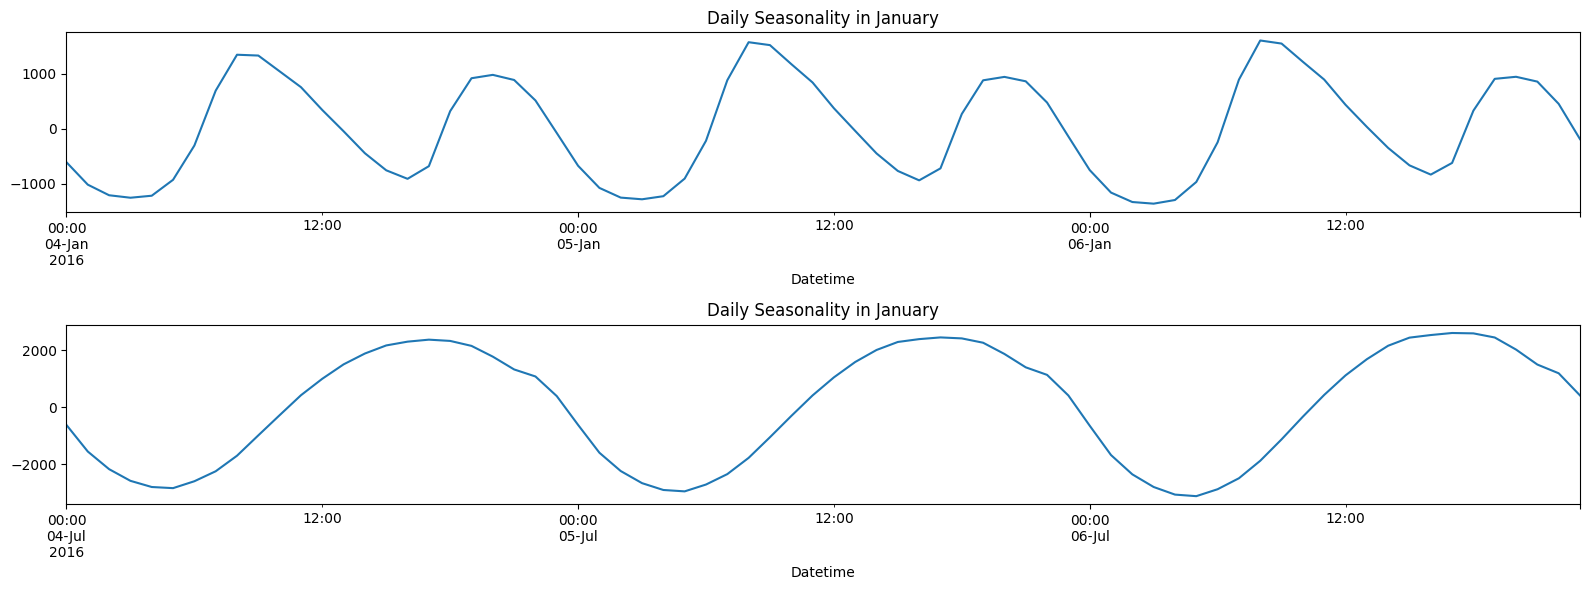

In [12]:
# Slice the data and plot the components individually. Start with the daily seasonal pattern:

fig, ax = plt.subplots(2, 1, figsize=(16, 6))
(results.seasonal['seasonal_24'].loc['2016-01-04': '2016-01-06'].plot(ax=ax[0],
                    title='Daily Seasonality in January'))

(results.seasonal['seasonal_24'].loc['2016-07-04': '2016-07-06'].plot(ax=ax[1],
                    title='Daily Seasonality in January'))

fig.tight_layout()
plt.show()


There is a repeating pattern of peaks during the day, which declines as it gets closer to the evening. Note that in the summertime, the daily pattern changes. For example, the daily pattern is similar in july, except the peak during the day is extended longer into later in the evening, possibly due to air conditioners being used at night before the weather cools down

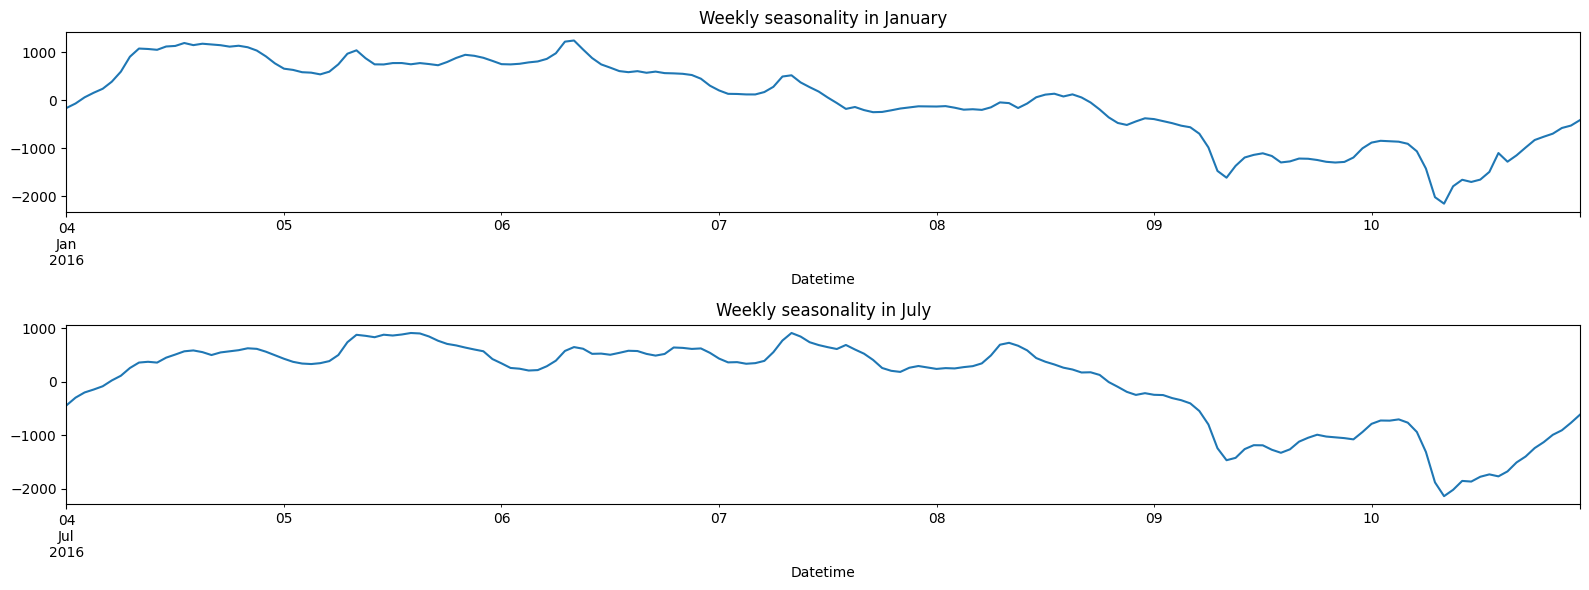

In [13]:
# Perform similar slice for the weekly seasonal pattern

mask = results.seasonal.index.month == 7

fig, ax = plt.subplots(2, 1, figsize=(16, 6))

(results.seasonal['seasonal_168'].loc['2016-01-04': '2016-01-10'].plot(ax=ax[0],
    title="Weekly seasonality in January"))

(results.seasonal['seasonal_168'].loc['2016-07-04': '2016-07-10'].plot(ax=ax[1],
    title="Weekly seasonality in July"))

fig.tight_layout()
plt.show()


There is a noticeable pattern of highs during weekdays that slowly decays during the weekend. During July, the sharper drop in th weekend is possibly due to people enjoying outdoor activities.

Overall, the results suggest an annual influence indicative of an annual seasonal pattern


We can try to update windows to [121, 121] for each seasonal component in the following code. The default values for windows are [11, 15]. The default value for iterate is 2, and we will update it to 5

In [14]:
mstl = MSTL(df, periods=(24, 24*7), iterate=4, windows=[121, 121])
results = mstl.fit()

In [21]:
del results

## Forecasting with multiple seasonal patterns using the Unobserved Components Model (UCM)

The Unobserved Components Model (UCM) is a technique that decomposes a time series, with multiple seasonal patterns. The UCM is also a forecasting model. Initially, the UCM was proposed as an alternative to the ARIMA model. 

Unlike an ARIMA model, the UCM decomposes a time series process by estimating its components and does not make assumptions regarding stationarity or distribution. An ARIMA model uses differencing to make a time series stationary.




There are situations where making a time series stationary - through differencing, is not achievable. The time series can also contain irregularities and other complexities. This is where UCM comes in as a more flexible and interpretable model. 

The UCM is based on the idea of latent variables or unobserved components of a time series, such as a level, trend and seasonality. These can be estimated from the observed variable. 

In statsmodels, the _UnobservedComponents_ class decomposes a time series into a trend component, a seasonal component, a cyclical component and an irregular component or error term. The equation can be generalized as the following: 

$y_{t} = \mu_{t} + \gamma_{t} + c_{t} + \epsilon_{t}$

where $y_{t}$ is the observed variable at time t, and $\mu_{t}, \gamma_{t}, c_{t}$ represent the trend, seasonal and cyclical components. The $\epsilon_{t}$ term is the irregular component (disturbance). We can have multiple seasons as well. The main idea in the UCM is that each component, called **state**, is modeled in a probabilistic manner, since they are unobserved. The UCM can also contain autoregressive and regression components to capture their effects



In [5]:
# Start by importing the UnobservedComponents class

from statsmodels.tsa.statespace.structural import UnobservedComponents

In [6]:
# Use the UCM model to forecast one month ahead
# Hold out one month to validate the model and split the data into train and test sets

train = df.iloc[:-month]
test = df.iloc[-month:]

<Axes: xlabel='Datetime'>

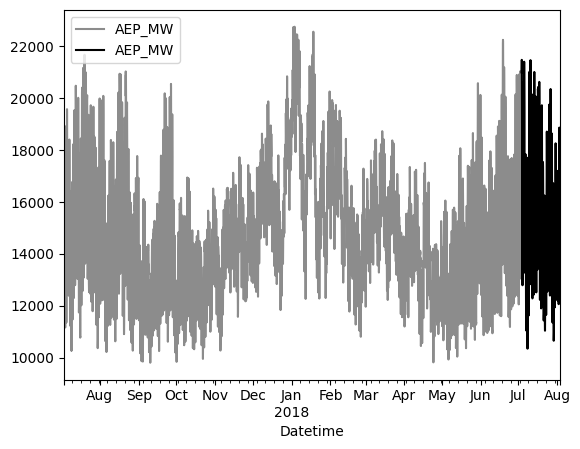

In [7]:
# We can plot the data to see the train and test splits
ax = train.iloc[-year:].plot(style='k-', alpha=0.45)

test.plot(ax=ax, style='k-')

The preceding code will display a time series split, one year's worth of hourly energy usage data from the train set, followed by one month of usage from the test set

UnobservedComponents takes several parameters. Of interest is freq_seasonal, which takes a dictionary for each frequency-domain seasonal component - for example, daily, weekly and annually. We will pass a list of key-value pairs for each period. Optionally, within each dictionary, we can also pass a key-value pair for harmonics. If no harmonic values are passed, then the default would be the np.floor(period/2)

In [8]:
# parameters 

params = {'level': 'dtrend', 
          'irregular': True, 
          'freq_seasonal': [{'period': day}, 
                            {'period': week}, 
                            {'period': year}],
        
            'stochastic_freq_seasonal': [False, False, False]}

model = UnobservedComponents(train, **params)

c:\Projekter\extra_venv\lib\site-packages\statsmodels\tsa\statespace\structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


In [9]:
# We can now fit the model on the trainining data using the fit method

results = model.fit()